In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold #used for cross-validation
from sklearn.ensemble import VotingClassifier

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

## Load data

In [2]:
%%time

parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

train = pd.read_csv('../input/dataset/dataset/sales_train.csv', parse_dates=['date'], date_parser=parser)
test = pd.read_csv('../input/dataset/dataset/test.csv')
items = pd.read_csv('../input/dataset/dataset/items.csv')
item_cats = pd.read_csv('../input/dataset/dataset/item_categories.csv')
shops=pd.read_csv('../input/dataset/dataset/shops.csv')

print('train:', train.shape, 'test:', test.shape)
print('items:', items.shape, 'item_cats:', item_cats.shape, 'shops:', shops.shape)

train: (2935849, 6) test: (214200, 3)
items: (22170, 3) item_cats: (84, 2) shops: (60, 2)
CPU times: user 14.5 s, sys: 2.05 s, total: 16.6 s
Wall time: 16.5 s


In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000,1.000
1,2013-01-03,0,25,2552,899.000,1.000
2,2013-01-05,0,25,2552,899.000,-1.000
3,2013-01-06,0,25,2554,"1,709.050",1.000
4,2013-01-15,0,25,2555,"1,099.000",1.000


In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Data analysis

In [8]:
print(train['date_block_num'].max())

33


In [9]:
print(train['item_cnt_day'].describe())

count   2,935,849.000
mean            1.243
std             2.619
min           -22.000
25%             1.000
50%             1.000
75%             1.000
max         2,169.000
Name: item_cnt_day, dtype: float64


In [10]:
train['item_cnt_day'].nlargest(25).values

array([2169., 1000.,  669.,  637.,  624.,  539.,  533.,  512.,  508.,
        504.,  502.,  501.,  500.,  500.,  480.,  412.,  405.,  401.,
        401.,  343.,  325.,  313.,  313.,  300.,  299.])

In [11]:
test_only = test[~test['item_id'].isin(train['item_id'].unique())]['item_id'].unique()
print('test only items:', len(test_only))

test only items: 363


## Preprocessing

In [12]:
# drop duplicates
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


In [13]:
# drop shops&items not in test data
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('train:', train.shape)

train: (1224429, 6)


In [14]:
from itertools import product

# create all combinations
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')
print(len(all_combi), 34 * len(test_shops) * len(test_items))

# group by monthly
train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')
train_base['item_cnt_day'].fillna(0, inplace=True)
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])

7282800 7282800


## Aggregate

In [15]:
# summary count by month
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index()
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order']
print(train_monthly[['item_cnt','item_order']].describe())

# trim count
train_monthly['item_cnt'].clip(0, 20, inplace=True)

train_monthly.head()

           item_cnt    item_order
count 7,282,800.000 7,282,800.000
mean          0.222         1.086
std           3.325         0.725
min          -4.000         1.000
25%           0.000         1.000
50%           0.000         1.000
75%           0.000         1.000
max       2,253.000        31.000


,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.000,1
1,0,2,31,0.000,1
2,0,2,32,0.000,1
3,0,2,33,1.000,1
4,0,2,38,0.000,1


### Feature creation

In [16]:
# pickup first category name
item_grp = item_cats['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_cats['item_group'] = pd.Categorical(item_grp).codes
#item_cats = item_cats.join(pd.get_dummies(item_grp, prefix='item_group', drop_first=True))
items = pd.merge(items, item_cats.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')

item_grp.unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

In [17]:
city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes

city.unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [18]:
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']
print(train_shop[['cnt_mean_shop','cnt_med_shop','cnt_std_shop']].describe())

train_shop.head()

       cnt_mean_shop  cnt_med_shop  cnt_std_shop
count    214,200.000   214,200.000   214,200.000
mean           0.188         0.054         0.381
std            0.608         0.509         0.773
min            0.000         0.000         0.000
25%            0.000         0.000         0.000
50%            0.029         0.000         0.171
75%            0.147         0.000         0.431
max           20.000        20.000        10.055


,shop_id,item_id,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop
0,2,30,0.118,0.000,0.327,1.000
1,2,31,0.235,0.000,0.741,1.088
2,2,32,0.324,0.000,0.638,1.088
3,2,33,0.324,0.000,0.535,1.029
4,2,38,0.000,0.000,0.000,1.000


In [19]:
# By shop,item_group
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
train_shop_cat.columns = ['shop_id','item_group','cnt_mean_shop_cat']
print(train_shop_cat.loc[:,['cnt_mean_shop_cat']].describe())

train_shop_cat.head()

       cnt_mean_shop_cat
count            546.000
mean               0.925
std                2.172
min                0.000
25%                0.029
50%                0.149
75%                0.467
max               13.382


,shop_id,item_group,cnt_mean_shop_cat
0,2,0,0.000
1,2,1,0.352
2,2,3,0.000
3,2,4,0.196
4,2,5,0.292


### Lags

In [20]:
# By month,shop,item At previous
train_prev = train_monthly.copy()
train_prev['date_block_num'] = train_prev['date_block_num'] + 1
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev']

for i in [2,12]:
    train_prev_n = train_monthly.copy()
    train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i
    train_prev_n.columns = ['date_block_num','shop_id','item_id','cnt_prev' + str(i),'order_prev' + str(i)]
    train_prev = pd.merge(train_prev, train_prev_n, on=['date_block_num','shop_id','item_id'], how='left')

train_prev.head()

,date_block_num,shop_id,item_id,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12
0,1,2,30,0.000,1,nan,nan,nan,nan
1,1,2,31,0.000,1,nan,nan,nan,nan
2,1,2,32,0.000,1,nan,nan,nan,nan
3,1,2,33,1.000,1,nan,nan,nan,nan
4,1,2,38,0.000,1,nan,nan,nan,nan


In [21]:
# By month,shop,item_group At previous
grp = pd.merge(train_prev, items, on=['item_id'], how='left').groupby(['date_block_num','shop_id','item_group'])
train_cat_prev = grp['cnt_prev'].mean().reset_index()
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'})
print(train_cat_prev.loc[:,['cnt_prev_cat']].describe())

train_cat_prev.head()

       cnt_prev_cat
count    18,564.000
mean          0.925
std           2.964
min           0.000
25%           0.000
50%           0.096
75%           0.396
max          20.000


,date_block_num,shop_id,item_group,cnt_prev_cat
0,1,2,0,0.000
1,1,2,1,0.280
2,1,2,3,0.000
3,1,2,4,0.000
4,1,2,5,0.100


### Crosstab

In [22]:
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()
train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# MACD At previous
col = np.arange(34)
pivT = train_piv[col].T
ema_s = pivT.ewm(span=4).mean().T
ema_m = pivT.ewm(span=12).mean().T
ema_l = pivT.ewm(span=26).mean().T
macd = ema_s - ema_l
sig = macd.ewm(span=9).mean()

ema_list = []
for c in col:
  sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']],
      pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}),
      pd.DataFrame(ema_m.loc[:,c]).rename(columns={c:'cnt_ema_m_prev'}),
      pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
      pd.DataFrame(macd.loc[:,c]).rename(columns={c:'cnt_macd_prev'}),
      pd.DataFrame(sig.loc[:,c]).rename(columns={c:'cnt_sig_prev'})], axis=1)
  sub_ema['date_block_num'] = c + 1
  ema_list.append(sub_ema)
    
train_ema_prev = pd.concat(ema_list)
train_ema_prev.head()

,shop_id,item_id,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,date_block_num
0,2,30,0.000,0.000,0.000,0.000,0.000,1
1,2,31,0.000,0.000,0.000,0.000,0.000,1
2,2,32,0.000,0.000,0.000,0.000,0.000,1
3,2,33,1.000,1.000,1.000,0.000,0.000,1
4,2,38,0.000,0.000,0.000,0.000,0.000,1


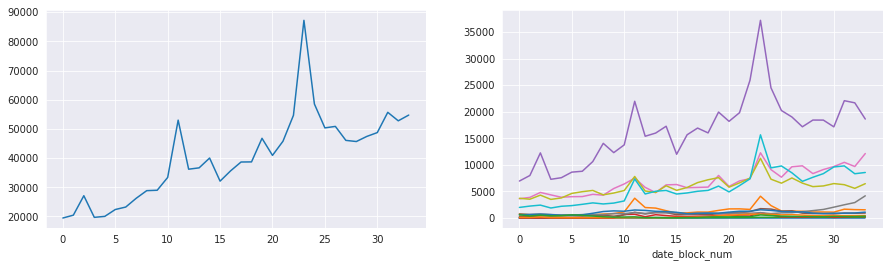

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

train_monthly.groupby(['date_block_num']).sum().reset_index()['item_cnt'].plot(ax=ax[0])
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
train_cat_monthly.pivot_table(index=['date_block_num'], columns=['item_group'], values='item_cnt', aggfunc=np.sum, fill_value=0).plot(ax=ax[1], legend=False)

### Item prices

In [25]:
# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]

# last price by shop,item
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

# null price by shop,item
'''
mean_price = price.groupby(['item_id'])['item_price'].mean().reset_index()
result_price = pd.merge(test, mean_price, on=['item_id'], how='left').drop('ID', axis=1)
pred_price_set = result_price[result_price['item_price'].isnull()]
'''
uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)

In [26]:
_ = '''
'''
if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner')
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner').drop(['item_name'], axis=1)
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
    pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner')
test_price.head()

,shop_id,item_id,item_price
209,2,1204,299.000
211,2,1224,399.000
219,2,1247,299.000
826,2,3656,299.000
1064,2,4531,279.000


### Discount rate

In [27]:
price_max = price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()

,item_id,item_max_price
0,30,399.000
1,31,699.000
2,32,349.000
3,33,499.000
4,38,"2,399.000"


In [28]:
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price'])
train_price_a.drop('item_max_price', axis=1, inplace=True)
train_price_a.head()

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,2,33,499.000,0.000
1,0,2,482,"3,300.000",0.000
2,0,2,491,600.000,0.000
3,0,2,839,"3,300.000",0.000
4,0,2,1007,449.000,0.626


In [29]:
test_price_a = pd.merge(test_price, price_max, on=['item_id'], how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price']
test_price_a['discount_rate'] = 1 - (test_price_a['item_price'] / test_price_a['item_max_price'])
test_price_a.drop('item_max_price', axis=1, inplace=True)
test_price_a.head()

,shop_id,item_id,item_price,discount_rate
0,2,1204,299.000,0.000
1,2,1224,399.000,0.111
2,2,1247,299.000,0.000
3,2,3656,299.000,0.143
4,2,4531,279.000,0.067


## Data preparation

In [30]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [31]:
def mergeFeature(df): 
  df = pd.merge(df, items, on=['item_id'], how='left').drop('item_group', axis=1)
  df = pd.merge(df, item_cats, on=['item_category_id'], how='left')
  df = pd.merge(df, shops, on=['shop_id'], how='left')

  df = pd.merge(df, train_shop, on=['shop_id','item_id'], how='left')
  df = pd.merge(df, train_shop_cat, on=['shop_id','item_group'], how='left')
  df = pd.merge(df, train_prev, on=['date_block_num','shop_id','item_id'], how='left')
  df = pd.merge(df, train_cat_prev, on=['date_block_num','shop_id','item_group'], how='left')
  df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')
  
  df['month'] = df['date_block_num'] % 12
  days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
  df['days'] = df['month'].map(days).astype(np.int8)
  
  df.drop(['shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_group'], axis=1, inplace=True)
  df.fillna(0.0, inplace=True)
  return reduce_mem_usage(df)

In [32]:
train_set = train_monthly[train_monthly['date_block_num'] >= 12]

train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')
train_set = mergeFeature(train_set)

train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column
X_train = train_set.drop(['item_cnt'], axis=1)
Y_train = train_set['item_cnt'].clip(0.,20.)
X_train.head()

Memory usage of dataframe is 871.85 MB --> 404.47 MB (Decreased by 53.6%)


,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,...,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.000,0.000,0,0.118,0.000,0.327,1.000,0.039,0.000,...,1.000,0.040,0.023,0.105,0.139,-0.116,-0.116,0,31,1
1,12,0.000,0.000,0,0.235,0.000,0.741,1.088,0.039,0.000,...,1.000,0.040,0.020,0.220,0.355,-0.335,-0.238,0,31,1
2,12,119.000,0.659,0,0.324,0.000,0.638,1.088,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,-0.140,0,31,1
3,12,199.000,0.601,0,0.324,0.000,0.535,1.029,0.039,1.000,...,1.000,0.040,0.883,0.507,0.403,0.480,0.070,0,31,1
4,12,0.000,0.000,0,0.000,0.000,0.000,1.000,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,0.049,0,31,1


In [33]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)

test_set['item_order'] = test_set['cnt_ema_s_prev'] #order_prev
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1

X_test = test_set.drop(['ID'], axis=1)
X_test.head()

assert(X_train.columns.isin(X_test.columns).all())

Memory usage of dataframe is 38.00 MB --> 18.18 MB (Decreased by 52.2%)


In [34]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

params={'learning_rate':0.8,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves':30,
        'verbose': 1,
        'random_state':0,
        'bagging_fraction':0.9,
        'feature_fraction':0.95 
       }

folds = GroupKFold(n_splits=4)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold, (trn_, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    reg = lgb.LGBMRegressor(**params, n_estimators=100)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=5, verbose=1)
    
    oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits

[1]	valid_0's rmse: 0.640303
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.334748
[3]	valid_0's rmse: 0.280699
[4]	valid_0's rmse: 0.267167
[5]	valid_0's rmse: 0.259444
[6]	valid_0's rmse: 0.255944
[7]	valid_0's rmse: 0.248941
[8]	valid_0's rmse: 0.245532
[9]	valid_0's rmse: 0.244592
[10]	valid_0's rmse: 0.242746
[11]	valid_0's rmse: 0.242071
[12]	valid_0's rmse: 0.242815
[13]	valid_0's rmse: 0.239968
[14]	valid_0's rmse: 0.239642
[15]	valid_0's rmse: 0.236955
[16]	valid_0's rmse: 0.236127
[17]	valid_0's rmse: 0.236178
[18]	valid_0's rmse: 0.235727
[19]	valid_0's rmse: 0.235747
[20]	valid_0's rmse: 0.235546
[21]	valid_0's rmse: 0.234767
[22]	valid_0's rmse: 0.235198
[23]	valid_0's rmse: 0.234836
[24]	valid_0's rmse: 0.234707
[25]	valid_0's rmse: 0.234857
[26]	valid_0's rmse: 0.23451
[27]	valid_0's rmse: 0.234512
[28]	valid_0's rmse: 0.234234
[29]	valid_0's rmse: 0.232049
[30]	valid_0's rmse: 0.232188
[31]	valid_0's rmse: 0.230573
[32]	valid_0's rmse

In [35]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

params={'learning_rate': 0.05,
'objective':'regression',
'metric':'rmse',
'num_leaves': 64,
'verbose': 1,
'random_state':42,
'bagging_fraction': 1,
'feature_fraction': 1
}

folds = GroupKFold(n_splits=6)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold, (trn, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)

    oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.152621
[1000]	valid_0's rmse: 0.133219
[1500]	valid_0's rmse: 0.120213
[2000]	valid_0's rmse: 0.111304
[2500]	valid_0's rmse: 0.103912
[3000]	valid_0's rmse: 0.0978228
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 0.0978228
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.171205
[1000]	valid_0's rmse: 0.159469
[1500]	valid_0's rmse: 0.152696
[2000]	valid_0's rmse: 0.148135
[2500]	valid_0's rmse: 0.144777
[3000]	valid_0's rmse: 0.142344
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 0.142344
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.152503
[1000]	valid_0's rmse: 0.132709
[1500]	valid_0's rmse: 0.119597
[2000]	valid_0's rmse: 0.110256
[2500]	valid_0's rmse: 0.102326
[3000]	valid_0's rmse: 0.0960881
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 0.09608